In [1]:
import numpy as np
from itertools import product
from lib import ent_heating_MPS,ent_cooling_MPS,ent_heating_statevec,ent_cooling_statevec,MPS,bipartite_split,level_spacing_spectrum

# Defining gates and simulation parameters

In [2]:
X = np.array([[0,1],[1,0]])
H = np.array([[1,1],[1,-1]]) / np.sqrt(2)
T = np.array([[1,0],[0,np.exp(1j * np.pi / 4)]])
S = np.array([[1,0],[0,1j]])
CNOT = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

In [3]:
# simulation parameters
realizations = 20
steps_heat = 200
steps_cool = 200
nWires = 6
gate_sets = (
    (CNOT,H,X),
    (CNOT,H,S),
    (CNOT,H,T),
)
beta = 10

# saving entanglement entropies
ent = np.zeros(shape=(2,len(gate_sets),realizations,steps_heat+steps_cool+2,nWires-1))
"""
First dimension corresponds to two smulation methods: MPS and statevector.

Second dimension corresponds to the gate set.

Third dimension corresponds to the realizations.

Fourth dimension corresponds to the step number within a simulation.

Fifth dimension corresponds to the number of qubits in each subsystem of the bipartitle system split.
"""

# saving singular values
singvals = np.zeros(shape=(2,len(gate_sets),realizations,2**int(nWires/2)))
"""
First dimension corresponds to two smulation methods: MPS and statevector.

Second dimension corresponds to the gate set.

Third dimension corresponds to the realizations.

Fourth dimension corresponds to the singular values in a bipartite split of the system.
"""

# saving bond dimensions
chi = np.zeros(shape=(len(gate_sets),realizations,nWires))
"""
First dimension corresponds to the gate set.

Second dimension corresponds to the realizations.

Third dimension corresponds to the bond.
"""

'\nFirst dimension corresponds to the gate set.\n\nSecond dimension corresponds to the realizations.\n\nThird dimension corresponds to the bond.\n'

# Simulations

In [4]:
for iMethod,method in enumerate(("MPS","statevec")):
    for iGates,gate_set in enumerate(gate_sets):
        iR = 0
        while iR < realizations:
            try:
                if method == "MPS":
                    # heating
                    psi,return_dict_heat = ent_heating_MPS(nWires,gate_set,steps_heat,eps=0)
                    # cooling
                    psi,return_dict_cool = ent_cooling_MPS(psi,gate_set,beta,steps_cool,eps=0)
                    chi[iGates,iR,:] = [S.shape[0] for S in psi.Ss]
                elif method == "statevec":
                    # heating
                    psi,return_dict_heat = ent_heating_statevec(nWires,gate_set,steps_heat,return_Svn=True)
                    # saving schmidt values for a bipartite split
                    singvals_iR = bipartite_split(psi)
                    singvals[0,iGates,iR,:] = bipartite_split(psi)
                    # cooling
                    psi,return_dict_cool = ent_cooling_statevec(psi,gate_set,beta,steps_cool)

                ent[iMethod,iGates,iR,:,:] = np.concatenate((return_dict_heat["Svn"],return_dict_cool["Svn"]))
                iR += 1
            except np.linalg.LinAlgError:
                print(f"    iR = {iR}: LinAlgError. Trying again.")
            if iR % 5 == 0: print("    iR = {} of {}".format(iR,realizations))
        print("Set {:3} of {} done.".format(len(gate_sets) * iMethod + iGates + 1,2 * len(gate_sets)))

    iR = 5 of 20
    iR = 10 of 20
    iR = 15 of 20
    iR = 20 of 20
Set   1 of 6 done.
    iR = 5 of 20
    iR = 10 of 20
    iR = 15 of 20
    iR = 20 of 20
Set   2 of 6 done.
    iR = 5 of 20
    iR = 10 of 20
    iR = 15 of 20
    iR = 20 of 20
Set   3 of 6 done.
    iR = 5 of 20
    iR = 10 of 20
    iR = 15 of 20
    iR = 20 of 20
Set   4 of 6 done.
    iR = 5 of 20
    iR = 10 of 20
    iR = 15 of 20
    iR = 20 of 20
Set   5 of 6 done.
    iR = 5 of 20
    iR = 10 of 20
    iR = 15 of 20
    iR = 20 of 20
Set   6 of 6 done.


# Plotting

In [5]:
import matplotlib.pyplot as plt
# mpl cosmetics
from matplotlib.lines import lineMarkers
from matplotlib.colors import BASE_COLORS
import matplotlib.patches as mpatches
lineMarkers = tuple(lineMarkers.keys())
baseColors = tuple(BASE_COLORS.keys())

gate_set_labels = ("H+X+CNOT","H+T+CNOT","H+S+CNOT")
method_labels = ("MPS","statevec")

Plotting the thermalization of MPS- and statevector method.

Text(0.5, 0, '#step')

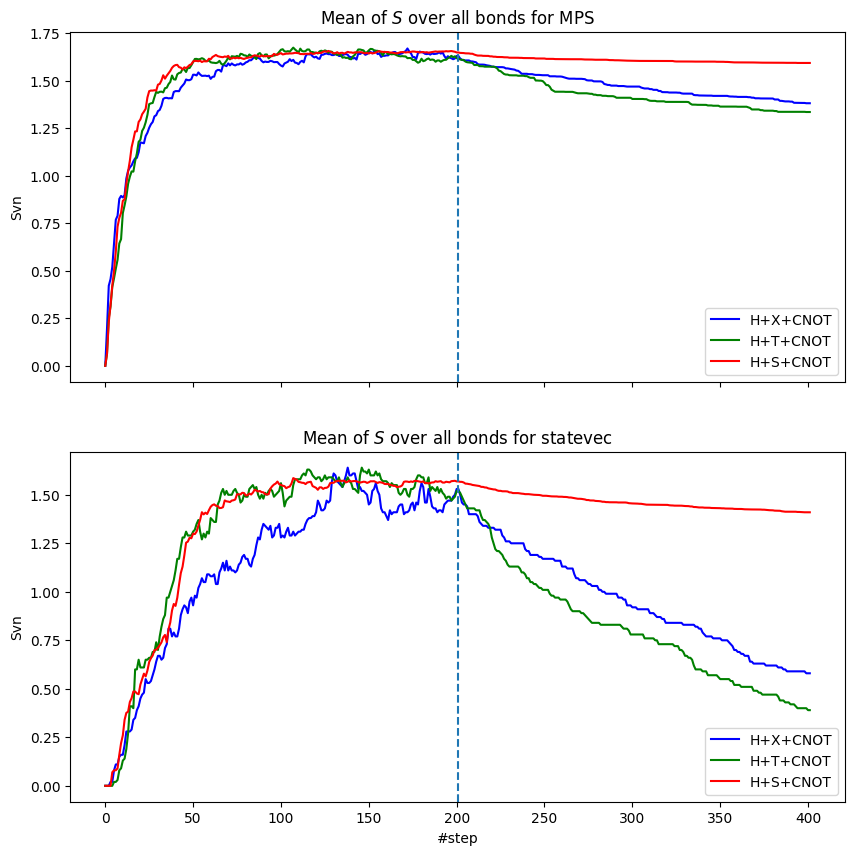

In [6]:
step_axis = np.arange(ent.shape[3])

fig_ent,ax_ent = plt.subplots(nrows=2,ncols=1,figsize=(10,10),sharex=True)
for iMethod in range(ent.shape[0]):
    for iGates in range(ent.shape[1]):
        ax_ent[iMethod].plot(step_axis,ent[iMethod,iGates,:,:,:].mean(axis=(0,2)),c=baseColors[iGates],label=gate_set_labels[iGates])
    ax_ent[iMethod].axvline(steps_heat+1,linestyle="--")
    ax_ent[iMethod].legend()
    ax_ent[iMethod].set_ylabel("Svn")
    ax_ent[iMethod].set_title("Mean of $S$ over all bonds for " + method_labels[iMethod])
ax_ent[1].set_xlabel("#step")

Bond dimensions for MPS

Text(0, 0.5, '$\\chi$')

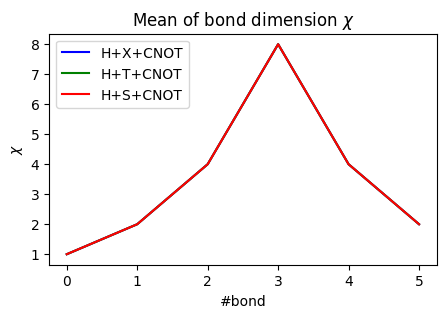

In [7]:
bond_axis = np.arange(nWires,dtype=int)

fig_chi,ax_chi = plt.subplots(nrows=1,ncols=1,figsize=(5,3))
for iGates in range(ent.shape[1]):
    ax_chi.plot(bond_axis,chi[iGates,:,:].mean(axis=(0,)),c=baseColors[iGates],label=gate_set_labels[iGates])
ax_chi.set_title("Mean of bond dimension $\chi$")
ax_chi.legend()
ax_chi.set_xlabel("#bond")
ax_chi.set_ylabel("$\chi$")

Text(0.5, 24.0, '#step')

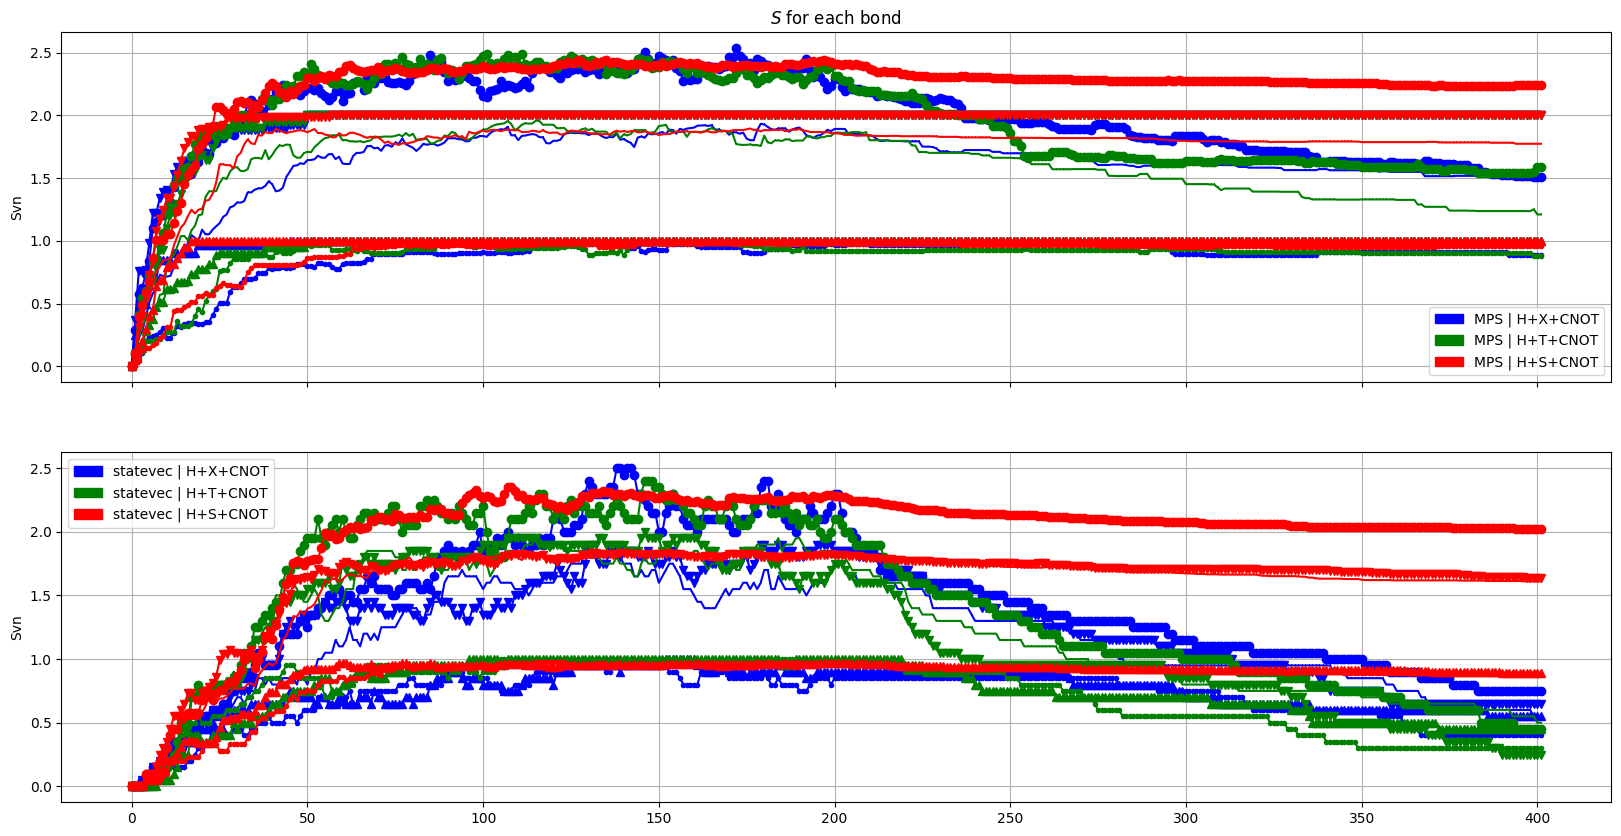

In [8]:
fig_ent_bond,ax_ent_bond = plt.subplots(nrows=2,ncols=1,figsize=(20,10),sharex=True)
for iMethod in range(ent.shape[0]):
    for iGates in range(ent.shape[1]):
        for iBond in range(nWires-1):
            ax_ent_bond[iMethod].plot(step_axis,ent[iMethod,iGates,:,:,iBond].mean(axis=(0,)),c=baseColors[iGates],marker=lineMarkers[iBond])
    ax_ent_bond[iMethod].legend(handles=[mpatches.Patch(color=baseColors[iGates],label=method_labels[iMethod] + " | " + gate_set_labels[iGates]) for iGates in range(ent.shape[1])])
    ax_ent_bond[iMethod].grid()
    ax_ent_bond[iMethod].set_ylabel("Svn")
ax_ent_bond[0].set_title("$S$ for each bond")
ax_ent[1].set_xlabel("#step")

/Users/hendrikkuhne/Library/Mobile Documents/com~apple~CloudDocs/QST_CMBP/project/lib/utils.py:102: RuntimeWarning: divide by zero encountered in divide
  ratios = spacings[:,1:] / spacings[:,:-1]
/Users/hendrikkuhne/Library/Mobile Documents/com~apple~CloudDocs/QST_CMBP/project/lib/utils.py:102: RuntimeWarning: invalid value encountered in divide
  ratios = spacings[:,1:] / spacings[:,:-1]


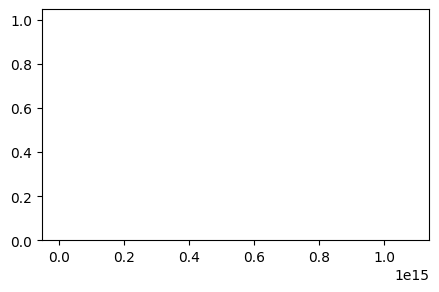

In [9]:
fig_ratio,ax_ratio = plt.subplots(nrows=1,ncols=1,figsize=(5,3))
for iGates in range(len(gate_sets)):
    ratios = level_spacing_spectrum(singvals[0,iGates,:,:]).mean(axis=(0,))
    ax_ratio.hist(ratios,label=gate_set_labels[iGates])